## [9주차 과제] 불응과 도구변수

불응과 도구변수를 이해하기 위한 과제입니다.

---
**과제 가이드**

- program_offered : 프로그램 제공 여부 (도구변수)
- program_participation : 실제 프로그램 참여 여부 (처치변수)
- post_test_score : 프로그램 후 시험 점수 (결과변수)
- 빈칸이 없는 부분은 확인용이니 확인 후 넘어가주세요.
---



과제 제출 기한: 2024년 7월 25일(목) 21:00<br>
제출 방법: `#24s-causal-inference` Slack 채널에 작성한 Notion 링크 공유<br>

*출제자: 임예빈<br>
최종 수정일: 2024년 7월 22일(월)*

In [1]:
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import matplotlib

## 11.1 불응


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data/9week.csv")

df.head()

,age,income,pre_test_score,attendance_score,program_offered,program_participation,post_test_score,tau,categ
0,38.6,9706.0,50.33,20.0,0,0,50.33,16.63,never-taker
1,49.0,14394.0,55.61,25.6,0,0,55.61,33.05,complier
2,45.4,2764.0,35.33,6.0,0,0,35.33,18.76,never-taker
3,36.5,1016.0,31.86,15.8,0,0,31.86,36.41,complier
4,41.1,4022.0,39.57,27.3,0,0,39.57,18.15,never-taker


In [3]:
df['categ'].value_counts()

categ
never-taker    5400
complier       4600
Name: count, dtype: int64

In [4]:
df['program_offered'].value_counts()

program_offered
0    5049
1    4951
Name: count, dtype: int64

## 11.2 잠재적 결과
불응을 더 정확하게 다루고 식별하려면 잠재적 결과 표기법을 확장해야할 필요가 있습니다. 여기선 Z _____ 가 Y _____에 미치는 영향인 처치 의도 효과(ITTE)를 단순선형회귀로 추정합니다.
(___를 채워주세요)

In [5]:
# ITTE 추정
m = smf.ols("post_test_score ~ program_offered ", data=df).fit()
print(m.summary().tables[1])

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          40.0047      0.180    222.730      0.000      39.653      40.357
program_offered    13.9904      0.255     54.808      0.000      13.490      14.491


In [6]:
# ATE 추정
df['tau'].mean()

25.981218000000005

In [7]:
# 단순선형회귀를 통한 ATE 추정
m = smf.ols("post_test_score ~ program_participation ", data=df).fit()
print(m.summary().tables[1])

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                40.1207      0.085    471.959      0.000      39.954      40.287
program_participation    29.7275      0.178    167.381      0.000      29.379      30.076


**Q1** 해당 데이터에서 ITTE는 어떤 것을 의미하나요?

## 11.3 도구변수 식별 가정
하지만 ATE를 식별할 수 없고 ITTE는 ATE에 대한 편향 추정값인 어려운 상황이므로 추가적인 가정이 필요합니다.

## 11.4 1단계
도구변수의 분석의 첫 번째 단계를 1단계 회귀(first stage)라고 부르는데 이는 처치변수를 도구변수에 대해 회귀하는 단계입니다.

In [8]:
first_stage = smf.ols("program_participation ~ program_offered", data=df).fit()
print(first_stage.summary().tables[1])

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        6.045e-15      0.005   1.22e-12      1.000      -0.010       0.010
program_offered     0.4627      0.007     65.937      0.000       0.449       0.476


In [9]:
df.groupby("categ").size()/len(df)

categ
complier       0.46
never-taker    0.54
dtype: float64

**Q2** 순응률은 얼마로 추정되고 연관성 가정이 유의미한 결과라고 생각하시나요? 이유와 함께 적어주세요.

## 11.5 2단계
도구변수의 두 번째 단계는 2단계 또는 축약형(reduced form)이라고 합니다. 이 단계에서는 결과를 도구변수에 회귀하여 처치 의도 효과를 추정합니다.

In [10]:
red_form = smf.ols("post_test_score ~ program_offered ", data=df).fit()
print(red_form.summary().tables[1])

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          40.0047      0.180    222.730      0.000      39.653      40.357
program_offered    13.9904      0.255     54.808      0.000      13.490      14.491


In [11]:
# late값 추정
late = (red_form.params['program_offered'] /
        first_stage.params['program_offered'])
late

30.23411149261892

In [12]:
df.groupby('categ')['tau'].mean()

categ
complier       35.285950
never-taker    18.054965
Name: tau, dtype: float64

**Q3** LATE 값을 구하기 위해 코드를 어떻게 작성했는지 설명하고, 그 이유를 설명해주세요.

## 11.6 2단계 최소제곱법


In [13]:
iv_regr = smf.ols('post_test_score~program_participation',
                  data = df.assign(program_offered=first_stage.fittedvalues)).fit()
print(iv_regr.summary().tables[1])

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                40.1207      0.085    471.959      0.000      39.954      40.287
program_participation    29.7275      0.178    167.381      0.000      29.379      30.076


## 11.7 표준오차


In [14]:
Z  = df['program_offered']
T = df['program_participation']
n = len(df)

# not the same as iv_regr.resid!
e_iv = df["post_test_score"] - iv_regr.predict(df)
compliance = np.cov(T, Z)[0, 1]/Z.var()

se = np.std(e_iv)/(compliance*np.std(Z)*np.sqrt(n))

print("SE IV:", se)
print("95% CI:", [late - 2*se, late + 2*se])

SE IV: 0.32258119027798415
95% CI: [29.58894911206295, 30.87927387317489]


In [15]:
from linearmodels import IV2SLS

formula = 'post_test_score ~ 1 +[program_participation ~ program_offered]'
iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="unadjusted")

print(iv_model.summary.tables[1])

                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
Intercept                 40.005     0.1051     380.73     0.0000      39.799      40.211
program_participation     30.234     0.3227     93.687     0.0000      29.602      30.867


**Q4** IV2SLS 모델을 사용하여 도구변수를 통한 회귀 분석을 수행하는 이유는 무엇인가요?

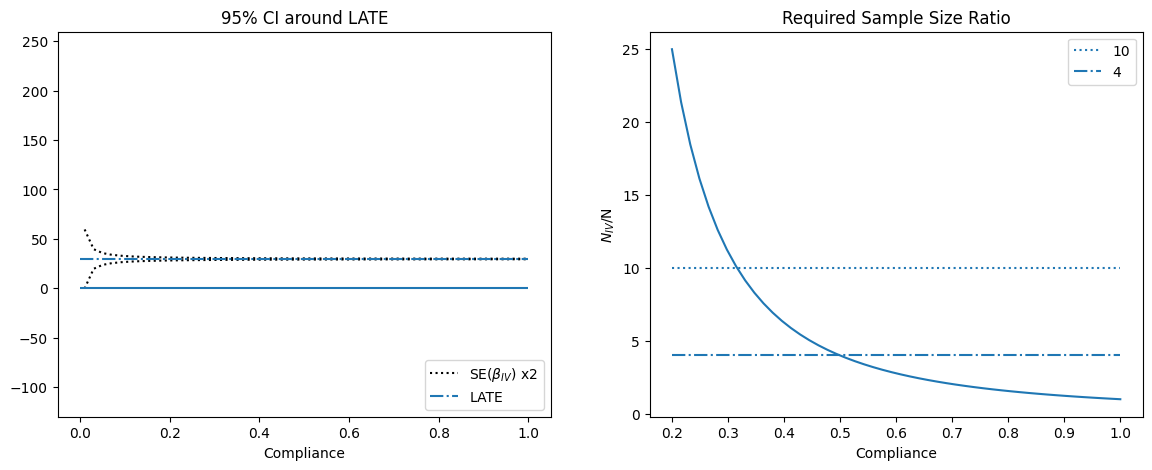

In [16]:
se_formula_iv = lambda compliance: np.std(e_iv)/(compliance*np.std(Z)*np.sqrt(n))
x = np.linspace(0.01, 1, 50)

effect = iv_regr.params["program_participation"]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(x, effect-se_formula_iv(x)*2, label="SE($\\beta_{IV}$) x2", ls=":", color="0")
ax1.plot(x, effect+se_formula_iv(x)*2, ls=":", color="0")
ax1.hlines(effect, 0, 1, ls="-.", label="LATE")
ax1.hlines(0, 0, 1)
ax1.set_xlabel("Compliance")
ax1.set_ylim(-(effect+100), (effect+100)*2)
ax1.legend(loc="lower right")
ax1.set_title("95% CI around LATE");


x = np.linspace(0.2, 1, 50)
ax2.plot(x, 1/(x**2))
ax2.hlines(10, 0.2, 1, ls=":", label="10")
ax2.hlines(4, 0.2, 1, ls="-.", label="4")
ax2.set_xlabel("Compliance")
ax2.set_ylabel("$N_{IV}$/N")
ax2.set_title("Required Sample Size Ratio")
ax2.legend()


**Q5** 해당 그래프를 통해 알 수 있는 것을 적어주세요.

## 11.8 통제변수와 도구변수 추가
2SLS 모델에 추가 도구변수를 포함하면, LATE 매개변수의 표준오차를 크게 줄일 수 있습니다

In [18]:
# attendance_score를 추가 도구변수로 포함해주세요
formula = 'post_test_score ~ 1 +[program_participation ~ program_offered + attendance_score]'
iv_model = IV2SLS.from_formula(formula, df).fit()

print(iv_model.summary.tables[1])

                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
Intercept                 39.976     0.0936     427.13     0.0000      39.792      40.159
program_participation     30.362     0.2532     119.92     0.0000      29.865      30.858


나이와 소득이 시험점수 향상에 도움이 된다고 가정하고 해당 변수를 추가 통제변수로 포함하여 표준오차가 줄여지는지 확인해보겠습니다.

In [19]:
formula = ''' post_test_score ~ 1
+[program_participation ~ program_offered + attendance_score]
+ income + age
'''

iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="unadjusted")

print(iv_model.summary.tables[1])

                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
Intercept                 30.098     0.1103     272.85     0.0000      29.882      30.315
income                    0.0017  2.794e-06     600.21     0.0000      0.0017      0.0017
age                       0.0457     0.0025     18.526     0.0000      0.0409      0.0505
program_participation     30.045     0.0414     725.86     0.0000      29.964      30.127


**Q6** 통제변수가 표준오차를 줄이는데 유의미한 영향을 미쳤나요? 판단한 근거와 함께 적어주세요.


### 11.8.1 2SLS 직접 구현


In [21]:
formula_1st = "program_participation ~ program_offered + attendance_score + income+age"
first_stage = smf.ols(formula_1st, data=df).fit()

iv_model = smf.ols(
    "post_test_score ~ program_participation + income + age",
    data=df.assign(prime_card=first_stage.fittedvalues)).fit()

print(iv_model.summary().tables[1])

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                30.3777      0.107    282.851      0.000      30.167      30.588
program_participation    29.5146      0.029   1032.882      0.000      29.459      29.571
income                    0.0017   2.75e-06    610.927      0.000       0.002       0.002
age                       0.0420      0.002     17.374      0.000       0.037       0.047


### 11.8.2 행렬 구현


In [23]:
Z = df[['program_offered', 'attendance_score', 'income', 'age']].values
X = df[['program_participation', 'income', 'age']].values
Y = df[['post_test_score']].values

def add_intercept(x):
    return np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)

Z_ = add_intercept(Z)
X_ = add_intercept(X)

# pre-multiplying Z_.dot(...) last is important to avoid
# creating a huge NxN matrix
X_hat = Z_.dot(np.linalg.inv(Z_.T.dot(Z_)).dot(Z_.T).dot(X_))

b_iv = np.linalg.inv(X_hat.T.dot(X_hat)).dot(X_hat.T).dot(Y)
b_iv[1]

array([30.04537296])

In [24]:
e_hat_iv = (Y - X_.dot(b_iv))

var = e_hat_iv.var()*np.diag(np.linalg.inv(X_hat.T.dot(X_hat)))

np.sqrt(var[1])

0.04139273741591478

In [25]:
t_tilde = smf.ols("program_participation ~ income + age", data=df).fit().resid

e_hat_iv.std()/(t_tilde.std()*np.sqrt(n*first_stage.rsquared))

0.04124227991119445

**Q7** 위에서 linearmodels 패키지를 사용한 방법과 행렬 연산을 통해 구현한 방법 중 어느 것이 도구변수 추정값을 얻는 데 더 적합할까요? 그 이유를 설명해주세요.

